In [16]:
import torch
from torch import optim, nn
import visdom
import torchvision
from torch.utils.data import DataLoader
from Preprocess import Anime
from net import ResNet18
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
batchze = 32
lr = 1e-3
epochs = 10
device = torch.device('cuda')
torch.manual_seed(1234)

In [3]:
# load data 
train_db = Anime('..\\Images', 512, 'train')
val_db = Anime('..\\Images', 512, 'val')
test_db = Anime('..\\Images', 512, 'test')

In [4]:
train_loader = DataLoader(train_db,batch_size= batchze, shuffle= True, num_workers=4)
val_loader = DataLoader(val_db,batch_size= batchze, num_workers=2)
test_loader = DataLoader(test_db,batch_size= batchze, num_workers=2)

In [5]:
def evaluate(model, loader):
    correct = 0
    total = len(loader.dataset)
    for x , y in loader:
        x, y  = x.to(device), y.to(device)
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(dim = 1)
        correct += torch.eq(pred, y).sum().float().item()
    return correct / total

In [13]:
viz = visdom.Visdom()

model = ResNet18(21).to(device)
optimizer = optim.Adam(model.parameters(),lr = lr)
criteon = nn.CrossEntropyLoss()
loss_data = []
val_acc_data = []
best_acc, best_epoch = 0, 0
global_step = 0
viz.line([0], [-1], win='loss', opts=dict(title='loss'))
viz.line([0], [-1], win='val_acc', opts=dict(title='val_acc'))
for epoch in range(epochs):
    for step, (x,y) in enumerate(train_loader):
        # x: [b,3,512,512] y:[b]
        x, y  = x.to(device), y.to(device)

        logits = model(x)
        loss = criteon(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        viz.line([loss.item()], [global_step], win='loss', update='append')
        loss_data.append(loss.item())
        global_step += 1
    if epoch % 1 == 0:
        val_acc = evaluate(model, val_loader)
        if val_acc > best_acc:
            best_epoch = epoch
            best_acc = val_acc
            torch.save(model.state_dict(),'best.mdl')
        viz.line([val_acc], [global_step], win='val_acc', update='append')
        val_acc_data.append(val_acc)
        print("step for " ,epoch, " = ",global_step)
print("best acc:", best_acc, "best epoch:", best_epoch)
model.load_state_dict(torch.load("best.mdl")) # load best state

print("loaded from checkpoint! ")

test_acc = evaluate(model, test_loader)
print("test acc:", test_acc)



Setting up a new session...


step for  0  =  48
step for  1  =  96
step for  2  =  144
step for  3  =  192
step for  4  =  240
step for  5  =  288
step for  6  =  336
step for  7  =  384
step for  8  =  432
step for  9  =  480
best acc: 0.8167539267015707 best epoch: 7
loaded from checkpoint! 
test acc: 0.7643979057591623


Text(0.5, 1.0, 'val_acc')

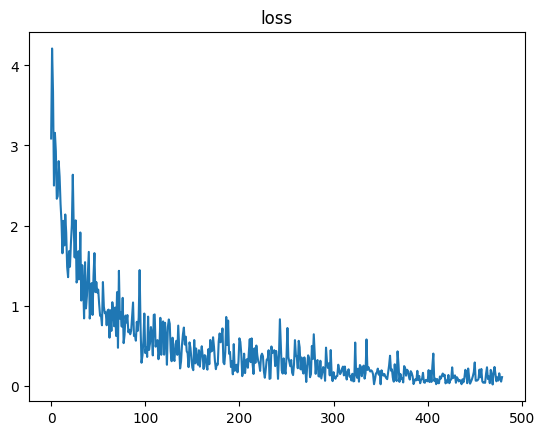

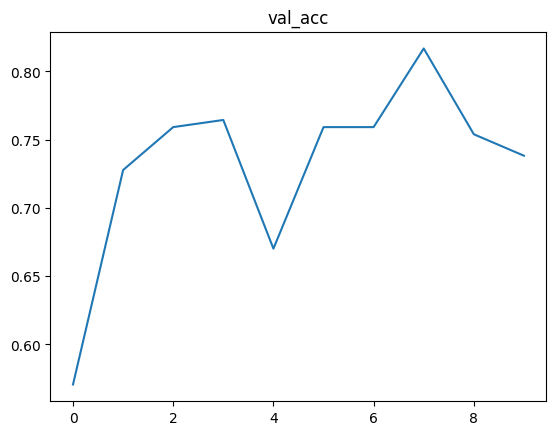

In [37]:
# display the picture of loss and val_acc
x = np.arange(0, global_step)
x_2 = np.arange(0,epoch + 1)
fig, ax = plt.subplots()
ax.plot(x, loss_data)
ax.set_title('loss')
fig2, ax2 = plt.subplots()
ax2.plot(x_2,val_acc_data)
ax2.set_title('val_acc')

In [19]:
# x = np.arange(0, global_step)
# fig, ax = plt.subplots()
ax.plot(x, val_acc_data)

ValueError: x and y must have same first dimension, but have shapes (480,) and (10,)